Performed for a run where the original graphs were run for 100 batchs

In [39]:
%load_ext autoreload
%autoreload 2
import logging
import os
from os.path import join as pj

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly_express as px
import scipy.sparse as sparse
import torch
from plotly import graph_objects as go
from sae_lens import SAE, ActivationsStore
from transformer_lens import HookedTransformer

from sae_cooccurrence.graph_generation import (
    load_subgraph,
    plot_subgraph_static,
)
from sae_cooccurrence.normalised_cooc_functions import (
    create_results_dir,
    get_sae_release,
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    analyze_representative_points,
    analyze_specific_points,
    calculate_pca_decoder,
    create_pca_plots_decoder,
    generate_data,
    generate_subgraph_plot_data_sparse,
    load_data_from_pickle,
    plot_doubly_clustered_activation_heatmap,
    plot_pca_explanation_and_save,
    plot_pca_feature_strength,
    plot_pca_single_feature_strength,
    plot_pca_with_active_features,
    plot_pca_with_top_feature,
    plot_simple_scatter,
    plot_subgraph_static_from_nx,
    plot_token_pca_and_save,
    save_data_to_pickle,
)
from sae_cooccurrence.streamlit import generate_color_palette
from sae_cooccurrence.utils.saving_loading import load_npz_files, set_device
from sae_cooccurrence.utils.set_paths import get_git_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up logging and paths


In [2]:
def setup_logging(log_path):
    logging.basicConfig(
        filename=log_path,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )


# Config -------------
torch.set_grad_enabled(False)
device = set_device()
git_root = get_git_root()

Using MPS


# Settings to perform PCA on a particular subgraph

In [3]:
save_figs = True
n_batches_generation = 100


# model_name = "gpt2-small"
# sae_release_short = "res-jb-feature-splitting"
# sae_id = "blocks.8.hook_resid_pre_24576"
# n_batches_reconstruction = 25

model_name = "gemma-2-2b"
sae_release_short = "gemma-scope-2b-pt-res-canonical"
sae_id = "layer_0/width_16k/canonical"
n_batches_reconstruction = 200
remove_special_tokens = True

activation_threshold = 1.5
subgraph_id = 1370

In [4]:
np.random.seed(1234)

fs_splitting_cluster = subgraph_id
pca_prefix = "pca"

# Load model
model = HookedTransformer.from_pretrained(model_name, device=device)

# Process the specific subgraph
sae_id_neat = neat_sae_id(sae_id)
results_dir = create_results_dir(
    model_name, sae_release_short, sae_id_neat, n_batches_generation
)
results_path = pj(git_root, results_dir)
activation_threshold_safe = str(activation_threshold).replace(".", "_")

figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)
pickle_file = pj(pca_path, f"pca_data_subgraph_{subgraph_id}.pkl")

# Set up logging
log_path = pj(pca_path, "pca_analysis.log")
setup_logging(log_path)

# Log all settings
logging.info("Script started")
logging.info("Settings:")
logging.info(f"  save_figs: {save_figs}")
logging.info(f"  git_root: {git_root}")
logging.info(f"  sae_id: {sae_id}")
logging.info(f"  activation_threshold: {activation_threshold}")
logging.info(f"  subgraph_id: {subgraph_id}")
logging.info(f"  fs_splitting_cluster: {fs_splitting_cluster}")
logging.info(f"  pca_prefix: {pca_prefix}")
logging.info(f"  model_name: {model_name}")
logging.info(f"  sae_release_short: {sae_release_short}")
logging.info(f"  n_batches_reconstruction: {n_batches_reconstruction}")
logging.info(f"  device: {device}")
logging.info(f"  results_path: {results_path}")
logging.info(f"  pca_path: {pca_path}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [5]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)
logging.info(
    f"Loaded node_df from {pj(results_path, f'dataframes/node_info_df_{activation_threshold_safe}.csv')}"
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

# with open(pj(results_path, f"subgraph_objects/activation_{activation_threshold_safe}/subgraph_{subgraph_id}.pkl"), 'rb') as f:
#     subgraph = pickle.load(f)


# Filter for the specific subgraph
fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

Loading npz files:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
regen_data = False
if not regen_data:
    raise ValueError("Are you sure you don't want to use existing data?")

ValueError: Are you sure you don't want to use existing data?

In [10]:
if not regen_data and os.path.exists(pickle_file):
    data = load_data_from_pickle(pickle_file)
    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]
else:
    sae_release = get_sae_release(model_name, sae_release_short)

    # Load SAE and set up activation store
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release=sae_release, sae_id=sae_id, device=device
    )
    sae.fold_W_dec_norm()

    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        streaming=True,
        store_batch_size_prompts=8,
        train_batch_size_tokens=4096,
        n_batches_in_buffer=32,
        device=device,
    )

    data = generate_data(
        model,
        sae,
        activation_store,
        fs_splitting_nodes,
        n_batches_reconstruction,
        decoder=False,
        remove_special_tokens=remove_special_tokens,
        device=device,
        # activation_threshold=10.0,
    )

    if regen_data:
        save_data_to_pickle(data, pickle_file)

    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]

In [8]:
# # Save pca_df as CSV
# pca_df_filename = f"pca_df_subgraph_{subgraph_id}.csv"
# pca_df.to_csv(pj(pca_path, pca_df_filename), index=False)

plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

plot_pca_explanation_and_save(pca, pca_path, subgraph_id, save=save_figs)

plot_simple_scatter(results, pca_path, subgraph_id, fs_splitting_nodes, save=save_figs)

if pca_decoder is not None:
    pca_decoder, pca_decoder_df = calculate_pca_decoder(sae, fs_splitting_nodes)
    # Save pca_decoder_df as CSV
    pca_decoder_df_filename = f"pca_decoder_df_subgraph_{subgraph_id}.csv"
    pca_decoder_df.to_csv(pj(pca_path, pca_decoder_df_filename), index=False)

    create_pca_plots_decoder(pca_decoder_df, subgraph_id, pca_path, save=save_figs)

print(f"Processing completed for subgraph ID {subgraph_id}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing completed for subgraph ID 1370


In [41]:
plot_pca_with_top_feature(
    pca_df, results, fs_splitting_nodes, fs_splitting_cluster, pca_path, save=save_figs
)

In [42]:
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC2",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC3",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

In [11]:
plot_pca_with_active_features(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    activation_threshold=activation_threshold,
    save=save_figs,
)

In [12]:
plot_doubly_clustered_activation_heatmap(
    results,
    fs_splitting_nodes,
    pca_df,
    pca_path,
    fs_splitting_cluster,
    max_examples=1000,
    save=save_figs,
)

In [19]:
analyze_representative_points(
    results=results,
    fs_splitting_nodes=fs_splitting_nodes,
    fs_splitting_cluster=fs_splitting_cluster,
    activation_threshold=activation_threshold,
    node_df=node_df,
    results_path=results_path,
    pca_df=pca_df,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing representative point 1:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 39
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 0.3027
Mean activation of non-zero non-feature splitting nodes: 3.2734
Median activation of non-zero feature splitting nodes: 0.3027
Median activation of non-zero non-feature splitting nodes: 1.1038
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 15
Sum of activation strengths for splitting features: 0.3027
Sum of activation strengths for non-splitting features: 124.3899

Analyzing representative point 2:


Number of non-zero features: 23
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 0.4615
Mean activation of non-zero non-feature splitting nodes: 4.6290
Median activation of non-zero feature splitting nodes: 0.4615
Median activation of non-zero non-feature splitting nodes: 1.4941
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 11
Sum of activation strengths for splitting features: 0.4615
Sum of activation strengths for non-splitting features: 101.8379

Analyzing representative point 3:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.2277
Mean activation of non-zero non-feature splitting nodes: 2.9216
Median activation of non-zero feature splitting nodes: 1.2277
Median activation of non-zero non-feature splitting nodes: 1.2821
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 26
Sum of activation strengths for splitting features: 1.2277
Sum of activation strengths for non-splitting features: 157.7681

Analyzing representative point 4:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.2277
Mean activation of non-zero non-feature splitting nodes: 2.9216
Median activation of non-zero feature splitting nodes: 1.2277
Median activation of non-zero non-feature splitting nodes: 1.2821
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 26
Sum of activation strengths for splitting features: 1.2277
Sum of activation strengths for non-splitting features: 157.7681

Analyzing representative point 5:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:624: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:625: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:625: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:626: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_c

Number of non-zero features: 44
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.6251
Mean activation of non-zero non-feature splitting nodes: 3.3963
Median activation of non-zero feature splitting nodes: 1.6251
Median activation of non-zero non-feature splitting nodes: 1.1159
Number of splitting features active above threshold: 1
Number of non-splitting features active above threshold: 19
Sum of activation strengths for splitting features: 1.6251
Sum of activation strengths for non-splitting features: 146.0398


In [23]:
# After creating the PCA plot and identifying interesting points
interesting_point_ids = [0]  # Replace with actual IDs of interest
analyze_specific_points(
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    pca_df,
    interesting_point_ids,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing point with ID 0:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [35]:
plot_subgraph_static(
    subgraph=load_subgraph(results_path, activation_threshold, subgraph_id),
    node_info_df=node_df,
    output_path=os.path.join(pca_path, "overall_subgraph"),
    activation_array=overall_feature_activations,
    normalize_globally=False,
    save_figs=True,
)

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [28]:
def plot_pca_2d_combo(
    pca_df,
    feature_activations,
    threshold,
    fs_splitting_nodes,
    exclude_feature=None,
):
    # Determine unique combinations of active features above the threshold
    active_features = feature_activations > threshold

    # If exclude_feature is specified, remove that feature from consideration
    if exclude_feature is not None:
        feature_idx = fs_splitting_nodes.index(exclude_feature)
        active_features = np.delete(active_features, feature_idx, axis=1)
        fs_splitting_nodes = [
            f for i, f in enumerate(fs_splitting_nodes) if i != feature_idx
        ]

    unique_combinations, combination_indices = np.unique(
        active_features, axis=0, return_inverse=True
    )

    # Create a color map for unique combinations
    n_combinations = len(unique_combinations)
    color_palette = generate_color_palette(n_combinations)
    color_map = dict(enumerate(color_palette))

    # Create figure with points grouped by feature combination for legend
    fig = go.Figure()

    # Add points for each unique combination of active features
    for combination_index in range(n_combinations):
        combination_points = combination_indices == combination_index
        if any(combination_points):
            # Map active features to their corresponding node indices
            active_node_indices = [
                fs_splitting_nodes[i]
                for i, active in enumerate(unique_combinations[combination_index])
                if active
            ]
            feature_combination_str = ", ".join(map(str, active_node_indices))

            fig.add_trace(
                go.Scatter(
                    x=pca_df.loc[combination_points, "PC1"],
                    y=pca_df.loc[combination_points, "PC3"],
                    mode="markers",
                    marker=dict(color=color_map[combination_index]),
                    name=f"Combination {combination_index}: {feature_combination_str}",
                    hovertemplate=(
                        "Token: %{customdata[0]}<br>"
                        "Context: %{customdata[1]}<br>"
                        "Feature Combination: " + feature_combination_str + "<br>"
                        "<extra></extra>"
                    ),
                    customdata=np.column_stack(
                        (
                            pca_df.loc[combination_points, "tokens"],
                            pca_df.loc[combination_points, "context"],
                        )
                    ),
                )
            )

    fig.update_layout(
        xaxis_title="PC1",
        yaxis_title="PC3",
        hovermode="closest",
        hoverdistance=5,
        # Move legend outside of plot
        legend=dict(
            yanchor="middle",
            y=0.5,
            xanchor="left",
            x=1.02,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="rgba(0,0,0,0.2)",
            borderwidth=1,
            font=dict(size=10),
        ),
        margin=dict(
            l=40, r=120, t=40, b=60
        ),  # Increased right margin to accommodate legend
        autosize=True,
    )

    return fig, color_map

In [33]:
fig, color_map = plot_pca_2d_combo(
    pca_df,
    results.all_graph_feature_acts.cpu(),
    15,
    fs_splitting_nodes,
)
fig.show()

In [16]:
def plot_pca_number_words(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Define number words to look for
    number_words = {
        "one": r"\b(one)\b",
        "two": r"\b(two)\b",
        "three": r"\b(three)\b",
        "four": r"\b(four)\b",
        "five": r"\b(five)\b",
        "six": r"\b(six)\b",
        "seven": r"\b(seven)\b",
        "eight": r"\b(eight)\b",
        "nine": r"\b(nine)\b",
        "ten": r"\b(ten)\b",
    }

    # Create a mask for each number word
    number_masks = {}
    for num, pattern in number_words.items():
        number_masks[num] = pca_df["tokens"].str.contains(pattern, case=False, na=False)

    # Create combined mask for non-number words
    non_number_mask = ~pd.concat(number_masks.values(), axis=1).any(axis=1)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot non-number words in grey
    ax.scatter(
        pca_df[non_number_mask]["PC1"],
        pca_df[non_number_mask]["PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="Not a number word",
    )

    # Plot each number word in a different color
    colors = plt.cm.tab10(np.linspace(0, 1, len(number_words)))  # type: ignore
    for (num, mask), color in zip(number_masks.items(), colors):
        if mask.any():
            ax.scatter(
                pca_df[mask]["PC1"],
                pca_df[mask]["PC3"],
                c=[color],
                alpha=0.6,
                s=50,
                label=num,
            )

    ax.set_title("PCA Analysis - Colored by Number Words")
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC3")
    ax.legend(title="Token Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_number_words_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_81896/3103870603.py:21: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



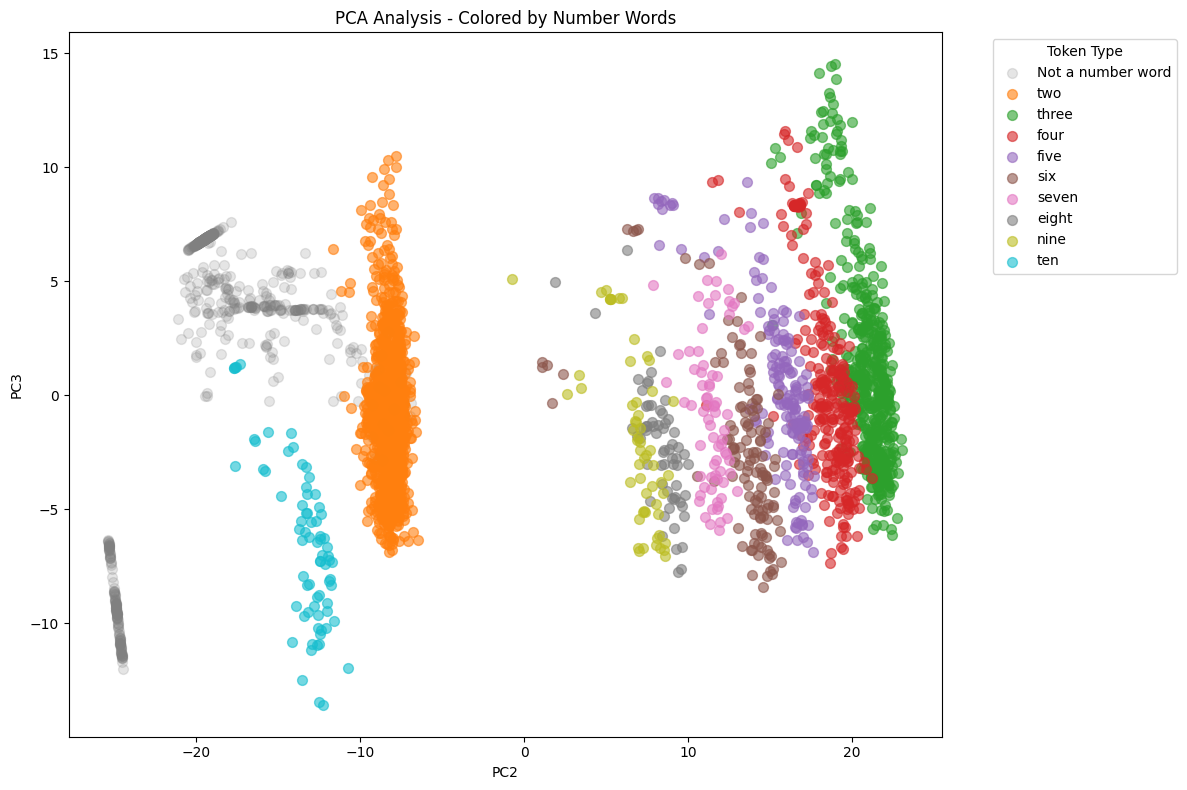

In [17]:
plot_pca_number_words(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [27]:
def plot_pca_number_words_plotly(
    pca_df, pca_path, fs_splitting_cluster, save_figs=False
):
    # Define number words to look for
    number_words = {
        "one": r"\b(one)\b",
        "two": r"\b(two)\b",
        "three": r"\b(three)\b",
        "four": r"\b(four)\b",
        "five": r"\b(five)\b",
        "six": r"\b(six)\b",
        "seven": r"\b(seven)\b",
        "eight": r"\b(eight)\b",
        "nine": r"\b(nine)\b",
        "ten": r"\b(ten)\b",
    }

    # Create a mask for each number word
    number_masks = {}
    for num, pattern in number_words.items():
        number_masks[num] = pca_df["tokens"].str.contains(pattern, case=False, na=False)

    # Create combined mask for non-number words
    non_number_mask = ~pd.concat(number_masks.values(), axis=1).any(axis=1)

    # Create figure
    fig = go.Figure()

    # Plot non-number words in grey
    fig.add_trace(
        go.Scatter(
            x=pca_df[non_number_mask]["PC1"],
            y=pca_df[non_number_mask]["PC3"],
            mode="markers",
            marker=dict(color="grey", opacity=1, size=5),
            name="Not a number word",
            hovertemplate="Token: %{customdata}<br><extra></extra>",
            customdata=pca_df[non_number_mask]["tokens"],
        )
    )

    # Plot each number word in a different color
    colors = px.colors.qualitative.Set2[: len(number_words)]
    for (num, mask), color in zip(number_masks.items(), colors):
        if mask.any():
            fig.add_trace(
                go.Scatter(
                    x=pca_df[mask]["PC1"],
                    y=pca_df[mask]["PC3"],
                    mode="markers",
                    marker=dict(color=color, opacity=1, size=5),
                    name=num,
                    hovertemplate="Token: %{customdata}<br><extra></extra>",
                    customdata=pca_df[mask]["tokens"],
                )
            )

    fig.update_layout(
        title="PCA Analysis - Colored by Number Words",
        xaxis_title="PC1",
        yaxis_title="PC3",
        showlegend=True,
        legend=dict(
            title="Token Type",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02,
            bgcolor="rgba(255, 255, 255, 0.8)",
        ),
        hovermode="closest",
        template="plotly_white",
    )

    if save_figs:
        fig.write_html(f"{pca_path}/pca_plot_number_words_{fs_splitting_cluster}.html")
        fig.write_image(
            f"{pca_path}/pca_plot_number_words_{fs_splitting_cluster}.png",
            width=800,
            height=800,
        )

    fig.show()

In [28]:
plot_pca_number_words_plotly(pca_df, pca_path, fs_splitting_cluster, save_figs)

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_66603/851642364.py:21: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [30]:
def plot_mean_activation_area_chart(
    pca_df, all_graph_feature_acts, fs_splitting_nodes, token_col="tokens"
):
    # Define number word groups
    number_words = {
        "one": r"\b(one)\b",
        "two": r"\b(two)\b",
        "three": r"\b(three)\b",
        "four": r"\b(four)\b",
        "five": r"\b(five)\b",
        "six": r"\b(six)\b",
        "seven": r"\b(seven)\b",
        "eight": r"\b(eight)\b",
        "nine": r"\b(nine)\b",
        "ten": r"\b(ten)\b",
    }

    # Filter out feature 1469
    # feature_mask = [node != 1469 and node != 6449 for node in fs_splitting_nodes]
    # filtered_fs_splitting_nodes = [
    #     node for node in fs_splitting_nodes if node != (1469 or 6449)
    # ]
    # filtered_feature_acts = all_graph_feature_acts[:, feature_mask]
    filtered_feature_acts = all_graph_feature_acts

    # Create masks for each number word
    groups = {
        num: pca_df[token_col].str.contains(pattern, case=False)
        for num, pattern in number_words.items()
    }

    # Calculate mean activations for each group
    mean_activations = {
        group: filtered_feature_acts[mask].mean(axis=0)
        for group, mask in groups.items()
    }

    # Prepare data for stacked area plot
    group_names = list(mean_activations.keys())
    feature_indices = np.arange(all_graph_feature_acts.shape[1])
    stacked_data = np.array([mean_activations[group] for group in group_names])

    # Plot stacked area chart
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        group_names,
        stacked_data.T,
        labels=[f"Node {fs_splitting_nodes[i]}" for i in feature_indices],
        alpha=0.7,
    )

    plt.title("Mean Activation of Features by Number Word")
    plt.xlabel("Number Word")
    plt.ylabel("Mean Activation")
    plt.legend(title="Feature Node", loc="upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
# plot_mean_activation_area_chart(pca_df, results.all_graph_feature_acts, fs_splitting_nodes)

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_66603/4129392473.py:28: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



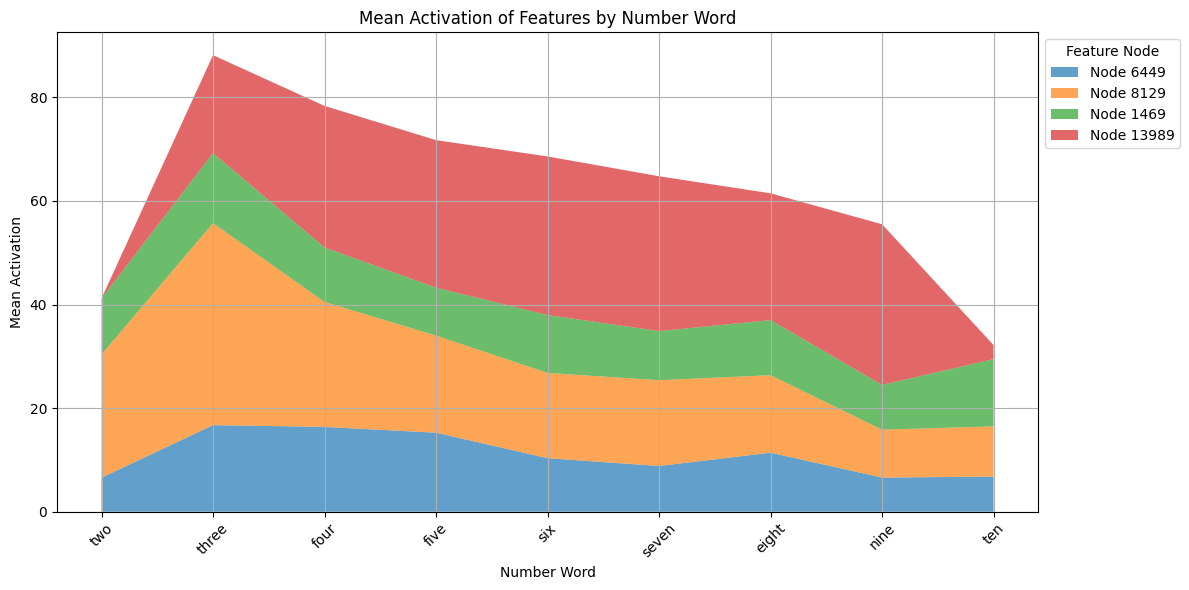

In [31]:
plot_mean_activation_area_chart(
    pca_df, results.all_graph_feature_acts.cpu(), fs_splitting_nodes
)

In [46]:
def plot_mean_activation_area_chart(
    pca_df,
    all_graph_feature_acts,
    fs_splitting_nodes,
    token_col="tokens",
):
    # Define number word groups
    number_words = {
        "one": r"\b(one)\b",
        "two": r"\b(two)\b",
        "three": r"\b(three)\b",
        "four": r"\b(four)\b",
        "five": r"\b(five)\b",
        "six": r"\b(six)\b",
        "seven": r"\b(seven)\b",
        "eight": r"\b(eight)\b",
        "nine": r"\b(nine)\b",
        "ten": r"\b(ten)\b",
    }

    # Create masks for each number word
    groups = {
        num: pca_df[token_col].str.contains(pattern, case=False)
        for num, pattern in number_words.items()
    }

    # Calculate mean activations for each group
    mean_activations = {
        group: all_graph_feature_acts[mask].mean(axis=0)
        for group, mask in groups.items()
    }

    # Prepare data for stacked area plot
    group_names = list(mean_activations.keys())
    feature_indices = np.arange(all_graph_feature_acts.shape[1])
    stacked_data = np.array([mean_activations[group] for group in group_names])

    # Normalize each column (number word) to sum to 1
    stacked_data = stacked_data / stacked_data.sum(axis=1)[:, np.newaxis]

    # Plot stacked area chart
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        group_names,
        stacked_data.T,
        labels=[f"Node {fs_splitting_nodes[i]}" for i in feature_indices],
        alpha=0.7,
    )

    plt.title("Normalized Feature Activation Distribution by Number Word")
    plt.xlabel("Number Word")
    plt.ylabel("Proportion of Total Activation")
    plt.legend(title="Feature Node", loc="upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_56913/2505342888.py:23: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



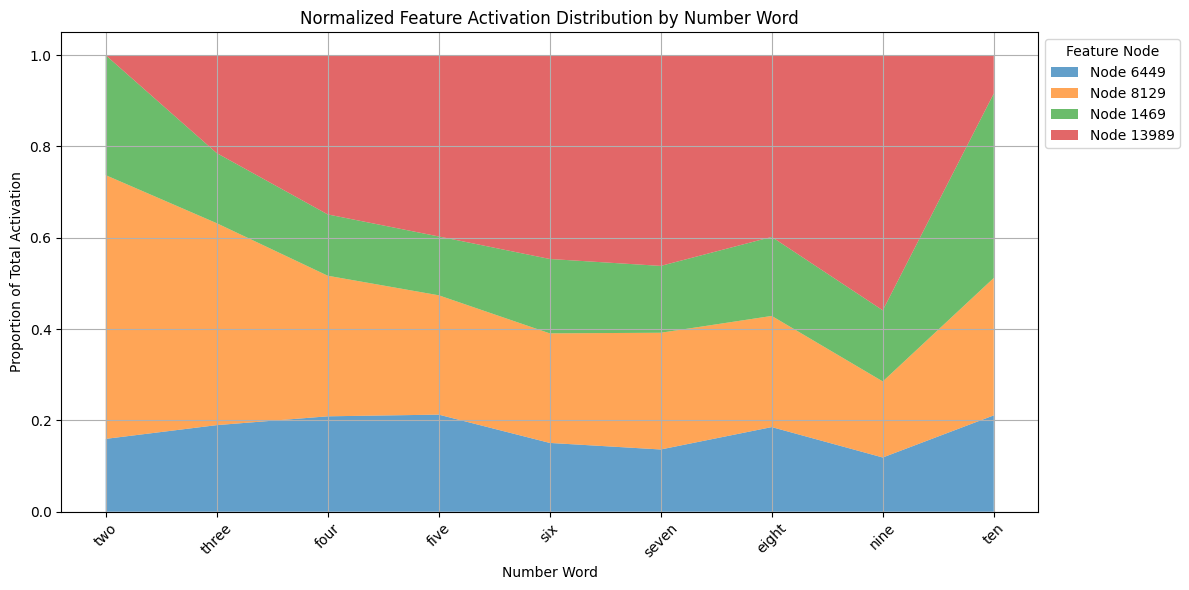

In [47]:
plot_mean_activation_area_chart(
    pca_df, results.all_graph_feature_acts.cpu(), fs_splitting_nodes
)

In [61]:
def plot_mean_activation_area_chart(
    pca_df,
    all_graph_feature_acts,
    fs_splitting_nodes,
    token_col="tokens",
):
    # Filter out feature 1469
    feature_mask = [node != 1469 and node != 6449 for node in fs_splitting_nodes]
    filtered_fs_splitting_nodes = [
        node for node in fs_splitting_nodes if node != (1469 or 6449)
    ]
    filtered_feature_acts = all_graph_feature_acts[:, feature_mask]

    # Define number word groups
    number_words = {
        "one": r"\b(one)\b",
        "two": r"\b(two)\b",
        "three": r"\b(three)\b",
        "four": r"\b(four)\b",
        "five": r"\b(five)\b",
        "six": r"\b(six)\b",
        "seven": r"\b(seven)\b",
        "eight": r"\b(eight)\b",
        "nine": r"\b(nine)\b",
        "ten": r"\b(ten)\b",
    }

    # Create masks for each number word
    groups = {
        num: pca_df[token_col].str.contains(pattern, case=False)
        for num, pattern in number_words.items()
    }

    # Calculate mean activations for each group using filtered features
    mean_activations = {
        group: filtered_feature_acts[mask].mean(axis=0)
        for group, mask in groups.items()
    }

    # Prepare data for stacked area plot
    group_names = list(mean_activations.keys())
    feature_indices = np.arange(filtered_feature_acts.shape[1])
    stacked_data = np.array([mean_activations[group] for group in group_names])

    # Normalize each column (number word) to sum to 1
    stacked_data = stacked_data / stacked_data.sum(axis=1)[:, np.newaxis]

    # Plot stacked area chart
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        group_names,
        stacked_data.T,
        labels=[f"Node {filtered_fs_splitting_nodes[i]}" for i in feature_indices],
        alpha=0.7,
    )

    plt.title("Normalized Feature Activation Distribution by Number Word (excl. 1469)")
    plt.xlabel("Number Word")
    plt.ylabel("Proportion of Total Activation")
    plt.legend(title="Feature Node", loc="upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_56913/3194286474.py:30: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



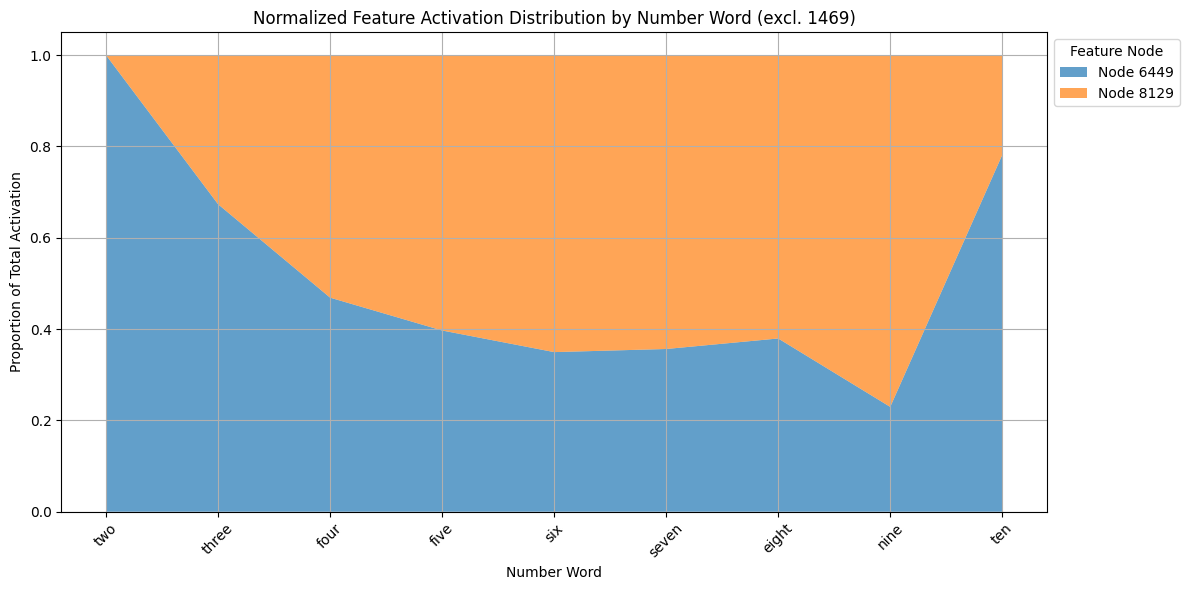

In [62]:
plot_mean_activation_area_chart(
    pca_df, results.all_graph_feature_acts.cpu(), fs_splitting_nodes
)

In [42]:
plot_pca_single_feature_strength(
    pca_df,
    results,
    8129,
    fs_splitting_cluster,
    pca_path,
    save=save_figs,
    pc_x="PC1",
    pc_y="PC3",
)

Plots saved as PNG: /Users/matthew/Documents/Github/sae_cooccurrence/figures/gemma-2-2b/gemma-scope-2b-pt-res-canonical/layer_0_width_16k_canonical/pca_1_5_subgraph_1370/pca_plot_graph_1370_feature_8129_PC1_vs_PC3.png
Plots saved as SVG: /Users/matthew/Documents/Github/sae_cooccurrence/figures/gemma-2-2b/gemma-scope-2b-pt-res-canonical/layer_0_width_16k_canonical/pca_1_5_subgraph_1370/pca_plot_graph_1370_feature_8129_PC1_vs_PC3.svg
Plots saved as HTML: /Users/matthew/Documents/Github/sae_cooccurrence/figures/gemma-2-2b/gemma-scope-2b-pt-res-canonical/layer_0_width_16k_canonical/pca_1_5_subgraph_1370/pca_plot_graph_1370_feature_8129_PC1_vs_PC3.html


In [41]:
plot_pca_single_feature_strength(
    pca_df,
    results,
    6449,
    fs_splitting_cluster,
    pca_path,
    save=save_figs,
    pc_x="PC1",
    pc_y="PC3",
)

Plots saved as PNG: /Users/matthew/Documents/Github/sae_cooccurrence/figures/gemma-2-2b/gemma-scope-2b-pt-res-canonical/layer_0_width_16k_canonical/pca_1_5_subgraph_1370/pca_plot_graph_1370_feature_6449_PC1_vs_PC3.png
Plots saved as SVG: /Users/matthew/Documents/Github/sae_cooccurrence/figures/gemma-2-2b/gemma-scope-2b-pt-res-canonical/layer_0_width_16k_canonical/pca_1_5_subgraph_1370/pca_plot_graph_1370_feature_6449_PC1_vs_PC3.svg
Plots saved as HTML: /Users/matthew/Documents/Github/sae_cooccurrence/figures/gemma-2-2b/gemma-scope-2b-pt-res-canonical/layer_0_width_16k_canonical/pca_1_5_subgraph_1370/pca_plot_graph_1370_feature_6449_PC1_vs_PC3.html


In [40]:
subgraph_id = fs_splitting_cluster
sparse_thresholded_matrix = sparse.load_npz(
    os.path.join(
        results_path, "thresholded_matrices", "sparse_thresholded_matrix_1_5.npz"
    ),
)
subgraph, subgraph_df = generate_subgraph_plot_data_sparse(
    sparse_thresholded_matrix=sparse_thresholded_matrix,
    node_df=node_df,
    subgraph_id=subgraph_id,
)
plot_subgraph_static_from_nx(
    subgraph=subgraph,
    output_path=pj(pca_path, "subgraph_static"),
    subgraph_df=subgraph_df,
    node_info_df=node_df,
    save_figs=True,
    show_plot=True,
)

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/pca.py:3209: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

